In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

import sys
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:30:03) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

# Breakdown the function get_data(symbol)

## Step 1 - Create features

In [5]:
location = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/"
jd = "jd000_d.csv"

df = pd.read_csv(location+jd, engine="python", header=None)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']

In [6]:
df.head()

,date,open,high,low,close,volume,open_interests
0,2013/11/08,4183,4186,4052,4072,350712,65726
1,2013/11/11,4076,4077,4017,4037,166804,70542
2,2013/11/12,4040,4085,4031,4077,114240,67840
3,2013/11/13,4079,4103,4061,4097,78388,66142
4,2013/11/14,4108,4108,4081,4103,48194,60106


In [7]:
def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df


def rebalance(unbalanced_data):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data.target==1] # get all all down days
    data_majority = unbalanced_data[unbalanced_data.target==0] # get all up days

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)

    # Display new class counts
    data_upsampled.target.value_counts()

    return data_upsampled


def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm


def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))

## Create master dataframes

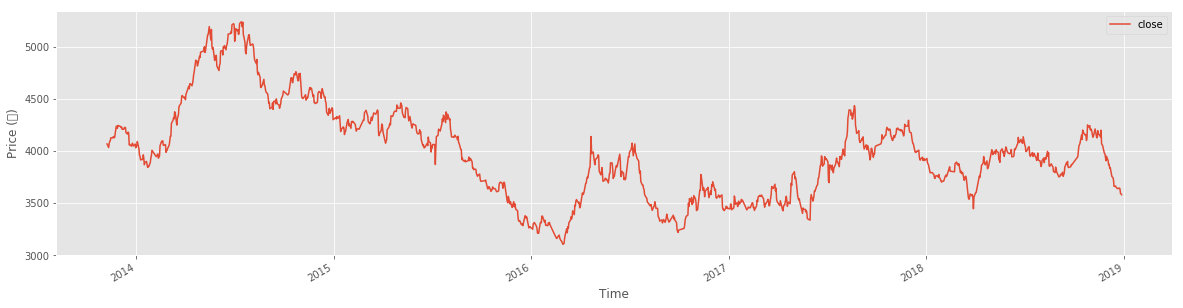

In [8]:
# Part 1:

master_df = get_data(df, 10)
data = master_df.copy()
data.index = pd.to_datetime(data.index)
data.tail(10)
data.describe()
ax = data[['close']].plot(figsize=(20, 5))
ax.set_ylabel("Price (￥)")
ax.set_xlabel("Time")
plt.show()

In [9]:
# Part 2:

data_train = data['2011-01-01':'2017-01-01']
# Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
data_train = rebalance(data_train).dropna()
# y as the label target 
y = data_train.target
# X as the dataframe with their values to be normalized
X = data_train.drop('target', axis=1)
X = normalize(X)

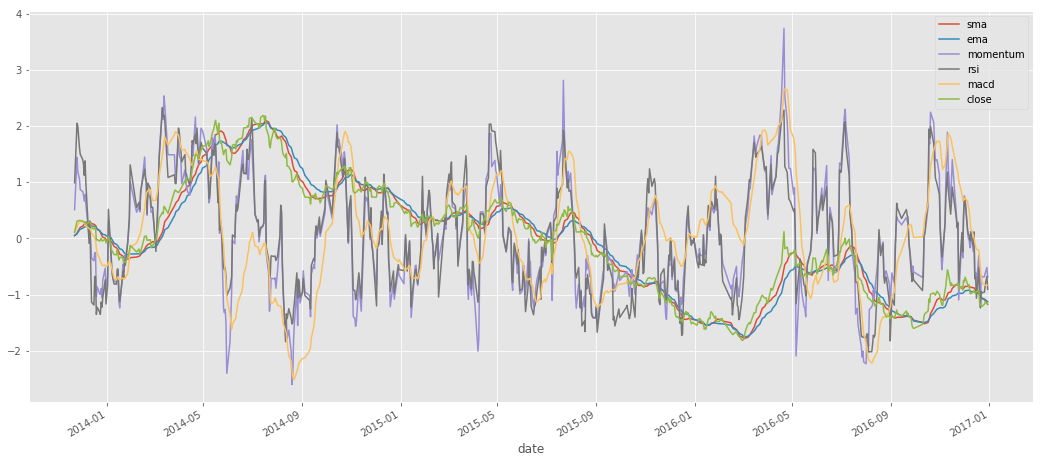

In [10]:
# Plotted chart based on normalized dataframe values. 
X.head(1000).plot(figsize = (18, 8))

In [11]:
data_val = data['2017-01-01':]
# y_val as the label target in the validation period
y_val = data_val.target
# X_val as the dataframe with their values to be normalized in the validation period
X_val = data_val.drop('target', axis=1)
# normalize
X_val = normalize(X_val.dropna())

In [12]:
# Part 3"
# Machine Learning

# Train test split
import sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

In [13]:
model = RandomForestClassifier(random_state=5)
model.fit(X_train, y_train)
scores(model, X_test, y_test)

Accuracy Score: 60.47 %
F1 Score: 0.6047
Area Under ROC Curve Score: 0.6109


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
# Trying to fix the bracket issue:
grid_data = [
              # Model 1 - RandomForestClassifier's parameters:
              {'n_estimators': [10, 50, 100],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 10, 50, 100],
               'min_samples_split': [2, 5, 10],
               'random_state': [5]}]

model_grid = list()

In [17]:
grid_data[0]

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 10, 50, 100],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100],
 'random_state': [5]}

In [18]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [19]:
grid = GridSearchCV(model, grid_data[0], scoring='f1').fit(X_train, y_train)
print(grid.best_params_)
model = grid.best_estimator_

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'random_state': 5, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'entropy', 'n_estimators': 50}


In [20]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [21]:
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred)
print("Accuracy Score: {0:0.2f} %".format(acc * 100))
print("F1 Score: {0:0.4f}".format(f1))
print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
print ("----------------------------------------------------")
print ("model", model)

Accuracy Score: 93.51 %
F1 Score: 0.9356
Area Under ROC Curve Score: 0.9352
----------------------------------------------------
model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


In [22]:
# Validation data
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print("Accuracy Score: {0:0.2f} %".format(acc * 100))
print("F1 Score: {0:0.4f}".format(f1))
print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
print ("----------------------------------------------------")
print ("model", model)

Accuracy Score: 55.85 %
F1 Score: 0.5035
Area Under ROC Curve Score: 0.5553
----------------------------------------------------
model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


In [26]:
grid

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'random_state': [5], 'min_samples_split': [2, 5, 10], 'max_depth': [None, 10, 50, 100], 'criterion': ['gini', 'entropy'], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

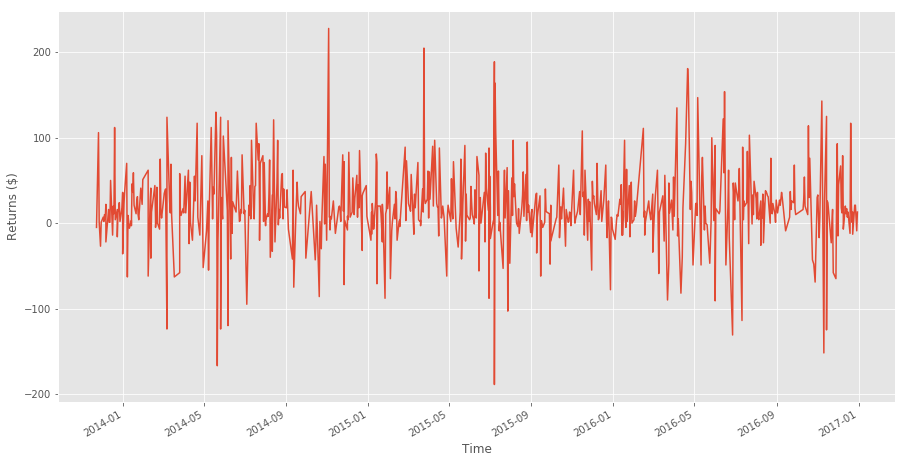

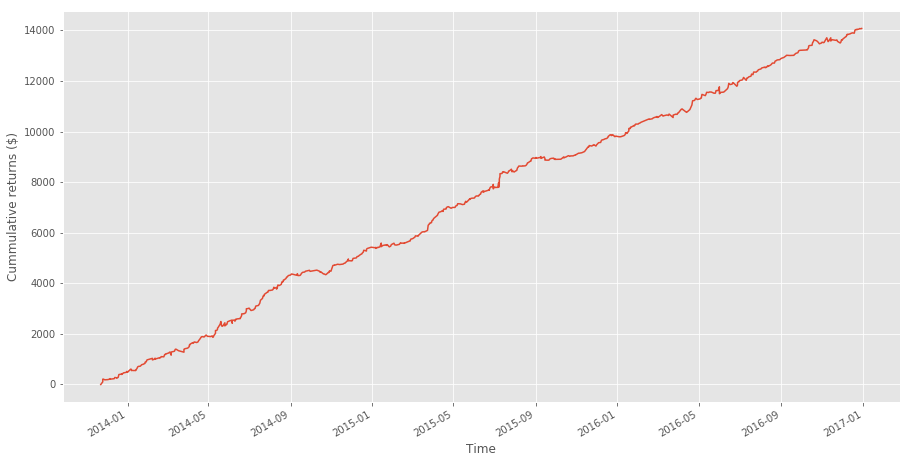

In [28]:
# See backtest of trained overfitted results:

# Trading system
# for i in range(1):
#     print ("======================================================================")
#     print ("Testing Model{}...".format(i+1))
rf_model = grid
y_pred = rf_model.predict(X)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['close'].diff()
data_returns = data_returns[X.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["close"][X.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(15, 8))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(15, 8))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

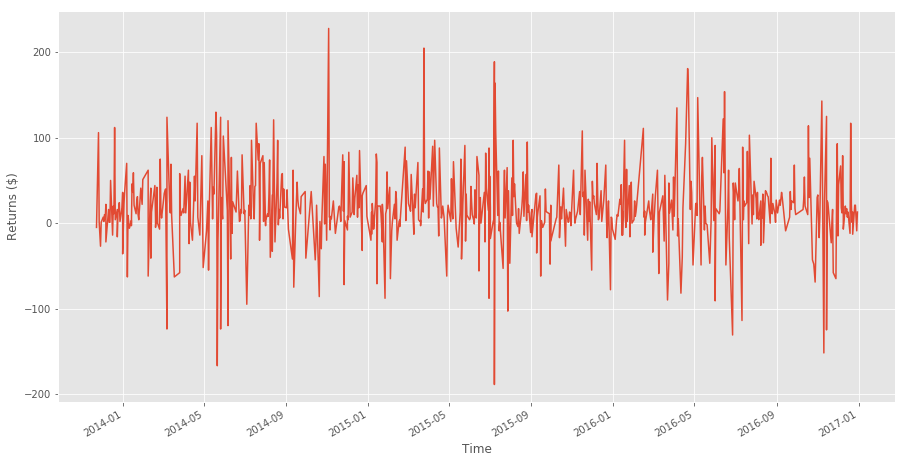

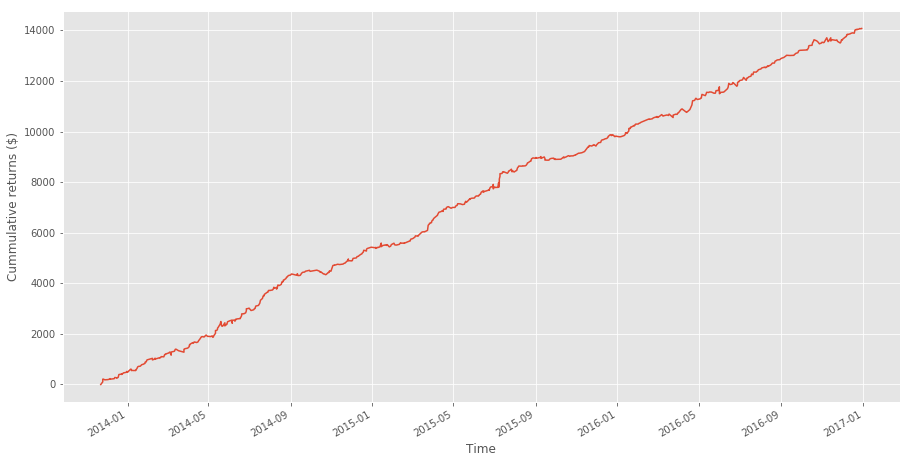

In [38]:
rf_model = model
y_pred = rf_model.predict(X)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['close'].diff()
data_returns = data_returns[X.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["close"][X.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(15, 8))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(15, 8))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

In [34]:
grid

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'random_state': [5], 'min_samples_split': [2, 5, 10], 'max_depth': [None, 10, 50, 100], 'criterion': ['gini', 'entropy'], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

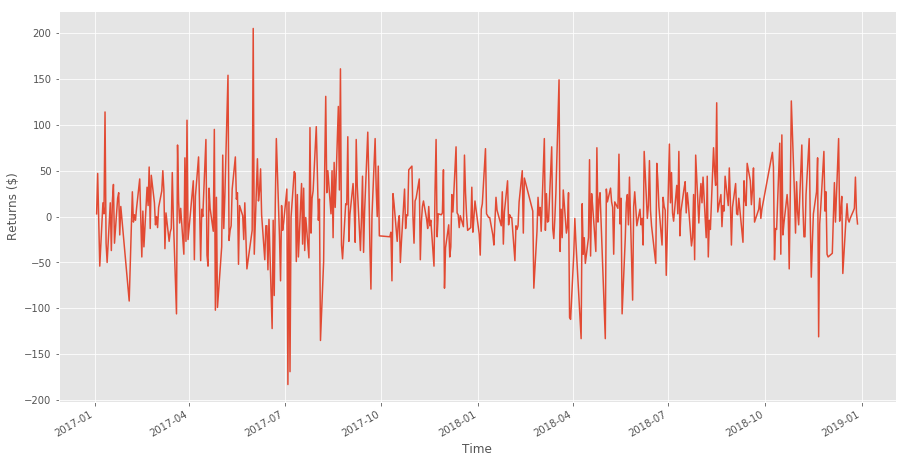

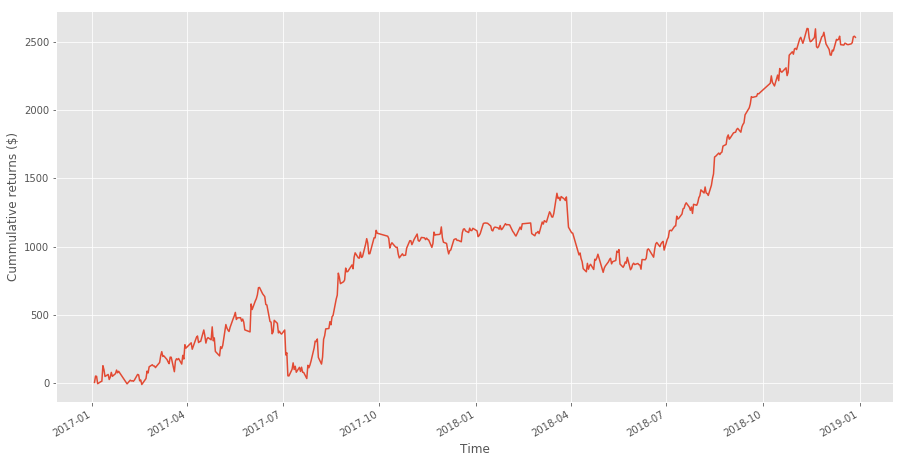

In [36]:
# Trading system: testing real performance:

rf_model = model
y_pred = rf_model.predict(X_val)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['close'].diff()
data_returns = data_returns[X_val.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["close"][X_val.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(15, 8))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(15, 8))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

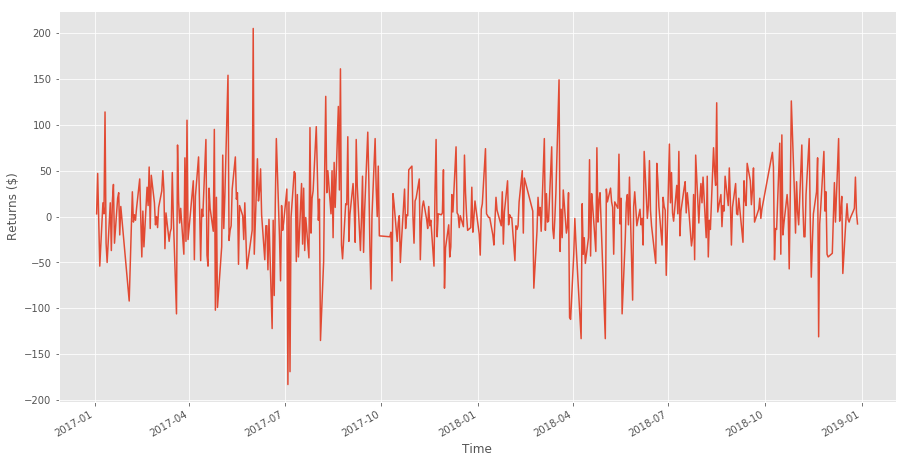

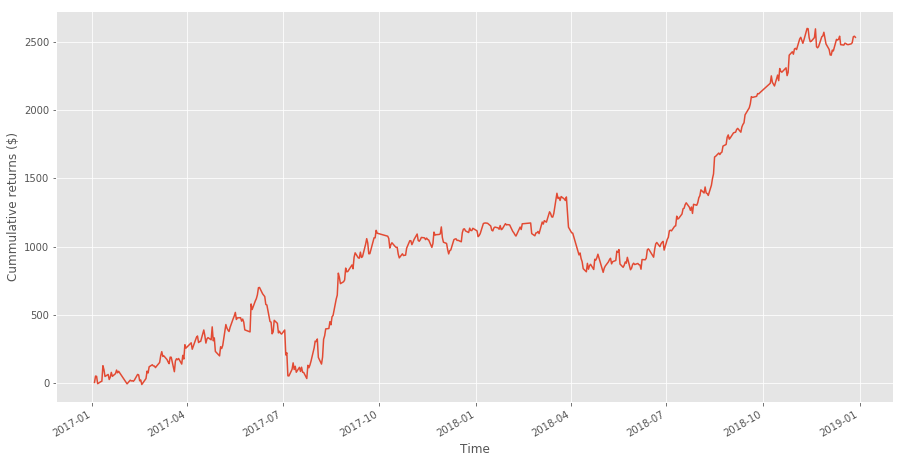

In [35]:

# for i in range(1):
#     print ("======================================================================")
#     print ("Testing Model{}...".format(i+1))


# Here the grid is the same as model itself
rf_model = grid
y_pred = rf_model.predict(X_val)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['close'].diff()
data_returns = data_returns[X_val.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["close"][X_val.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(15, 8))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(15, 8))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

# Summarize and explore ML algos' packages/paras with python

## OLS

https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

In [33]:
# OLS:
import statsmodels.formula.api as sm

In [23]:
sm.ols?

sm.ols(formula, data, subset=None, drop_cols=None, *args, **kwargs)

## lasso ridge and elastic

https://www.ricequant.com/community/topic/3951

In [26]:
from sklearn import linear_model

## Group lasso

## Ridge

##  Elastic net

## nnls

## svm

https://quant.la/Article/View/33/%E7%94%A8Python-%E5%AE%9E%E7%8E%B0%E4%B8%80%E4%B8%AA-SVM-%E5%88%86%E7%B1%BB%E5%99%A8-%E7%AD%96%E7%95%A5.html

In [34]:
from sklearn import svm

In [36]:
svm.LinearSVC?

## svr

## markov

## hmm

In [2]:
from hmmlearn.hmm import GaussianHMM

In [3]:
GaussianHMM?

In [ ]:
model = GaussionHMM(n_components = n, covariance_type = 'full', n_iter=2000).fit()

## gbdt

## neural network

## genetic algo

## decision tree

## random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
RandomForestClassifier?

## PCA

## DL